<a href="https://colab.research.google.com/github/igor185/research-paper-implementation/blob/main/neural-style-transfer/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>A Neural Algorithm of Artistic Style</center></h1>

[Paper link](https://arxiv.org/abs/1508.06576)

# Architecture overview

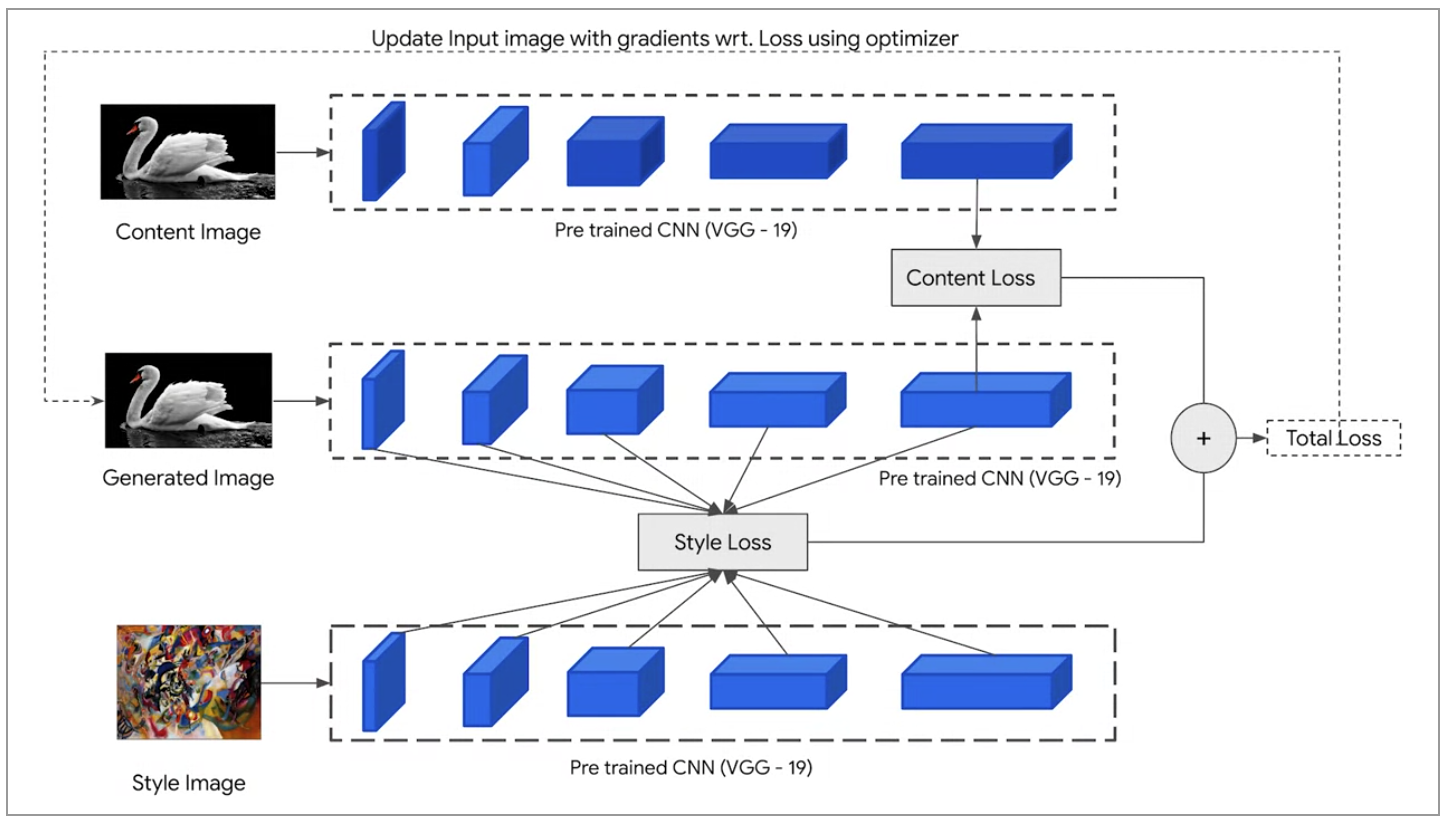

# Build model

In [39]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm

In [7]:
def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image

Layers to output from VGG

In [3]:
# style layers of interest
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

In [5]:
def get_model(layer_names, image_shape=(256, 256, 3), model="vgg"):
  if model == "vgg":
    model = tf.keras.applications.vgg19.VGG19(input_shape=image_shape, include_top=False, weights='imagenet')
    model.trainable = False
    outputs = [model.get_layer(name).output for name in layer_names]
  
    model = tf.keras.Model(inputs=model.input, outputs=outputs)

    return model

In [6]:
model = get_model(style_layers + content_layers)

80150528/80134624 [==============================] - 0s 0us/step


In [8]:
def style_loss(features, targets):
  return tf.reduce_mean(tf.square(features - targets))

def content_loss(features, targets):
  return 0.5 * tf.reduce_sum(tf.square(features - targets))

In [9]:
def gram_matrix(input_tensor):
  # calculate the gram matrix of the input tensor
  input_tensor = tf.expand_dims(input_tensor, axis=0)
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram[0]

In [10]:
def get_features(images, model):
  preprocessed_images = preprocess_image(images)

  features = model(preprocessed_images)

  styles = features[:len(style_layers)]
  contents = features[len(style_layers):]

  styles = [tf.convert_to_tensor([gram_matrix(i) for i in styles_of_image]) for styles_of_image in styles]

  return styles, contents

In [28]:
def step(content, generated, style, style_weight=2e-2, content_weight=1e-2):
  with tf.GradientTape() as tape:
    images = tf.stack([content, generated, style])
    
    styles, contents = get_features(images, model)

    generated_image_styles = [i[1] for i in styles]
    style_images_styles = [i[2] for i in styles]

    style_loss_value = tf.add_n([style_loss(generated_image_styles[i], style_images_styles[i]) for i in range(len(style_layers))])

    content_image_content = contents[0][0]
    generated_image_content = contents[0][1]

    content_loss_value = content_loss(generated_image_content, content_image_content)

    total_loss = style_weight*style_loss_value + content_weight*content_loss_value

  gradients = tape.gradient(total_loss, generated)

  return gradients, (style_loss_value, content_loss_value)

In [12]:
def get_optimizer():
  return tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

In [34]:
def optimize(content, style, num_iterations=1000, print_interval=100, optimizer=None):

  optimizer = get_optimizer()
  
  generated_image = tf.cast(content, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  for i in tqdm(range(num_iterations)):
    if i != 0 and i % print_interval == 0:
      cv2_imshow(generated_image.numpy())
      print("iter: {}, style: {}, content: {}".format(i, loss[0], loss[1]))

    gradients, loss = step(content, generated_image, style)

    optimizer.apply_gradients([(gradients, generated_image)])

    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=255.0))
  
  return generated_image.numpy()

Download images

In [41]:
!wget -q --no-check-certificate -O content.jpg 'https://docs.google.com/uc?export=download&id=1GFRDQUsU-hWMRcE_ADAr2vSNubGEjJ3D'
!wget -q --no-check-certificate -O style.jpg 'https://docs.google.com/uc?export=download&id=1lku86OoJ37Nzc10p6LtAX7gl0YJq4azs'
!wget -q --no-check-certificate -O city.jpg 'https://docs.google.com/uc?export=download&id=14ou4EmTWiEYOW_QAp7Ki3Zk6i7CWbIWE'

In [42]:
style = cv2.imread("style.jpg")
content = cv2.imread("content.jpg")
city = cv2.imread("city.jpg")


style = cv2.resize(style, (256, 256))
content = cv2.resize(content, (256, 256))
city = cv2.resize(city, (256, 256))

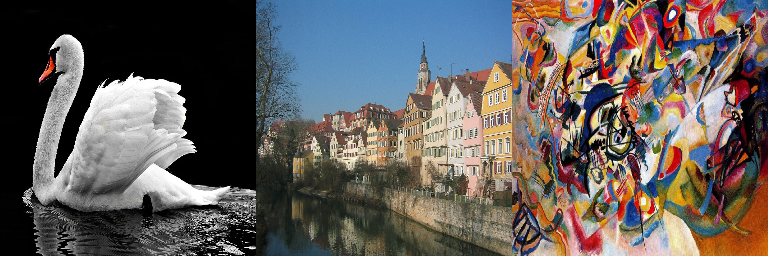

In [44]:
cv2_imshow(np.concatenate([content, city, style], axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1000 [00:00<?, ?it/s]

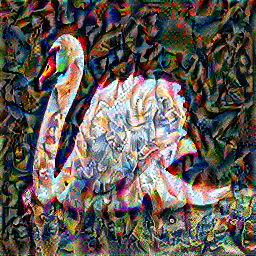

iter: 100, style: 1844698112.0, content: 428026176.0


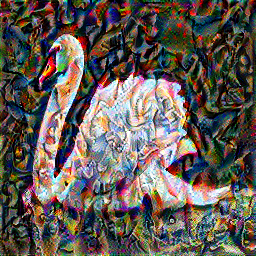

iter: 200, style: 1221134080.0, content: 411219040.0


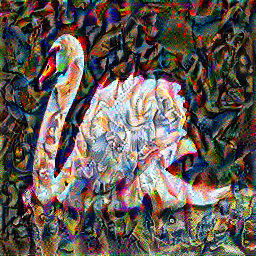

iter: 300, style: 1053757760.0, content: 403925696.0


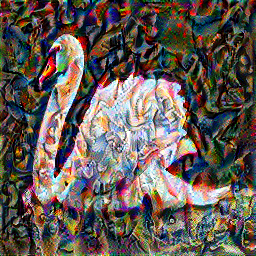

iter: 400, style: 984995840.0, content: 400368064.0


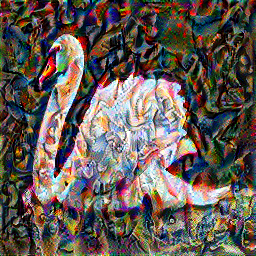

iter: 500, style: 951347904.0, content: 398681664.0


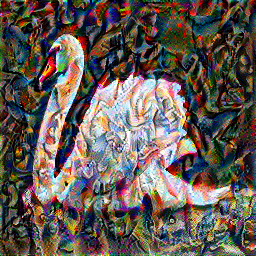

iter: 600, style: 933861696.0, content: 397753376.0


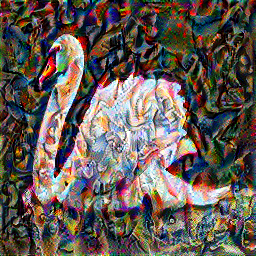

iter: 700, style: 924578176.0, content: 397265120.0


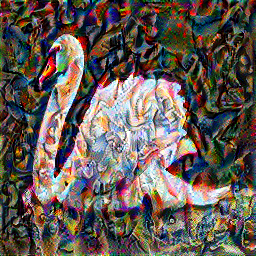

iter: 800, style: 919584832.0, content: 396984224.0


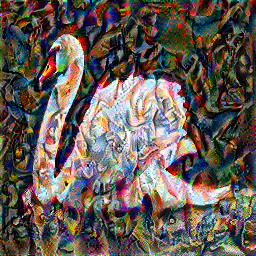

iter: 900, style: 916884864.0, content: 396834432.0


In [38]:
img = optimize(content, style)

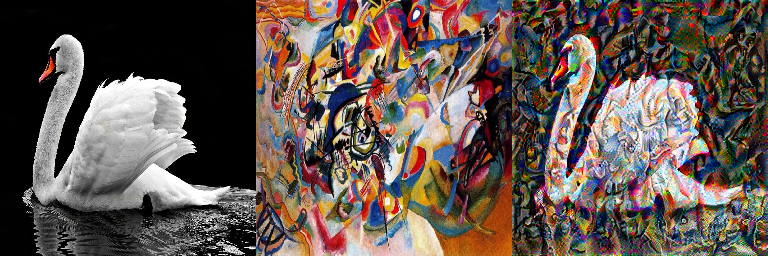

In [40]:
cv2_imshow(np.concatenate([content, style, img], axis=1))

  0%|          | 0/1000 [00:00<?, ?it/s]

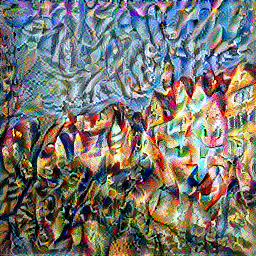

iter: 100, style: 2431497216.0, content: 301738944.0


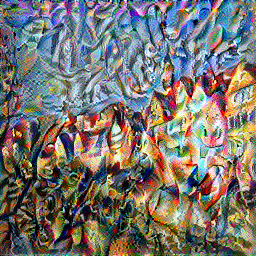

iter: 200, style: 1512136960.0, content: 292810304.0


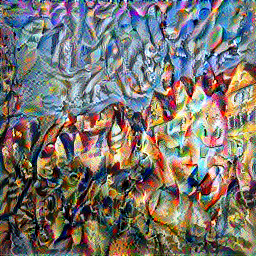

iter: 300, style: 1274407808.0, content: 287963968.0


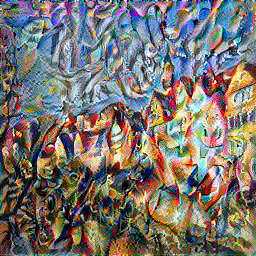

iter: 400, style: 1176578560.0, content: 285315552.0


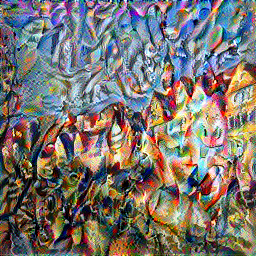

iter: 500, style: 1128994432.0, content: 284056832.0


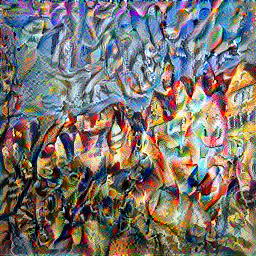

iter: 600, style: 1104519040.0, content: 283373632.0


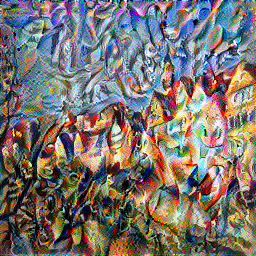

iter: 700, style: 1091566464.0, content: 282981664.0


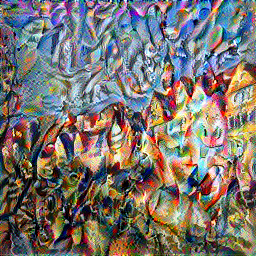

iter: 800, style: 1084641664.0, content: 282748448.0


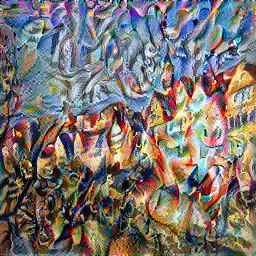

iter: 900, style: 1080908032.0, content: 282622400.0


In [45]:
img = optimize(city, style)

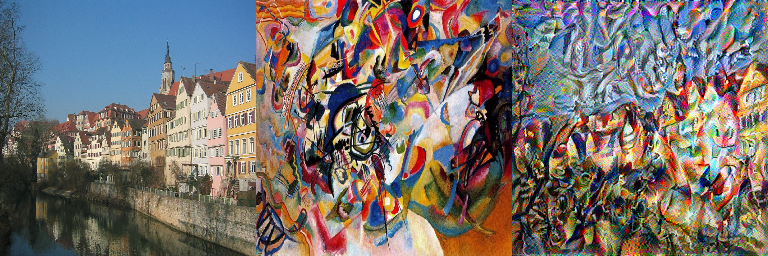

In [46]:
cv2_imshow(np.concatenate([city, style, img], axis=1))